In [9]:
%load_ext autoreload
%autoreload 2
import sys
if ".." not in sys.path:
    sys.path.append("..")

import numpy as np
from scipy.integrate import cumulative_trapezoid
from scipy.special import gamma
import matplotlib
import matplotlib.pyplot as plt
from typing import Callable

from volterra_hawkes.kernel.exponential_kernel import ExponentialKernel
from volterra_hawkes.kernel.constant_kernel import ConstantKernel
from volterra_hawkes.kernel.fractional_kernel import FractionalKernel
from volterra_hawkes.kernel.gamma_kernel import GammaKernel
from volterra_hawkes.kernel.mittag_leffler_kernel import MittagLefflerKernel
from volterra_hawkes.kernel.kernel import Kernel
from volterra_hawkes.utility.mittag_leffler import mittag_leffler

my_green = "#5b6c64"
my_copper = "#B56246"
plt.rcParams["figure.figsize"]        = ((1 + np.sqrt(5)) / 2 * 5, 5)
plt.rcParams["figure.autolayout"]     = True
plt.rcParams["patch.force_edgecolor"] = False
plt.rcParams["axes.grid"]             = True
plt.rcParams['axes.prop_cycle']       = matplotlib.cycler(color=[my_green, my_copper, "#322B4D", "#28BC9C", "#71074E"]) 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
def kernel_test(K: Kernel, t_grid, explicit_kernel: Callable):
    fig, ax = plt.subplots(3, 2, figsize=(10, 10))

    K_grid = K(t_grid)
    ax[0, 0].plot(t_grid, K_grid)
    ax[0, 0].plot(t_grid, explicit_kernel(t_grid), "--")
    ax[0, 0].set_title("$K$")

    K_bar_grid = K.integrated_kernel(t_grid)

    ax[0, 1].plot(t_grid, K_bar_grid)
    ax[0, 1].plot(t_grid, cumulative_trapezoid(K_grid, t_grid, initial=0), "--")
    ax[0, 1].set_title("Integrated $K$")

    ax[1, 0].plot(t_grid, K.double_integrated_kernel(t_grid))
    ax[1, 0].plot(t_grid, cumulative_trapezoid(K_bar_grid, t_grid, initial=0), "--")
    ax[1, 0].set_title("Double Integrated $K$")

    R_grid = K.resolvent(t_grid)
    K_mat = np.tril(K(t_grid[:, None] - t_grid[None, :]), k=-1)
    dt = t_grid[1] - t_grid[0]

    ax[1, 1].plot(t_grid, K_mat @ R_grid * dt)
    ax[1, 1].plot(t_grid, R_grid - K_grid, "--")
    ax[1, 1].set_title("Resolvent $K * R = R - K$")
    
    ax[2, 0].plot(t_grid, K.inv_integrated_kernel(K.integrated_kernel(t_grid)))
    ax[2, 0].plot(t_grid, t_grid, "--")
    ax[2, 0].set_title(r"$\bar K^{-1}(\bar K(t))$")

    plt.show()

## Constant kernel $K(t) = c$

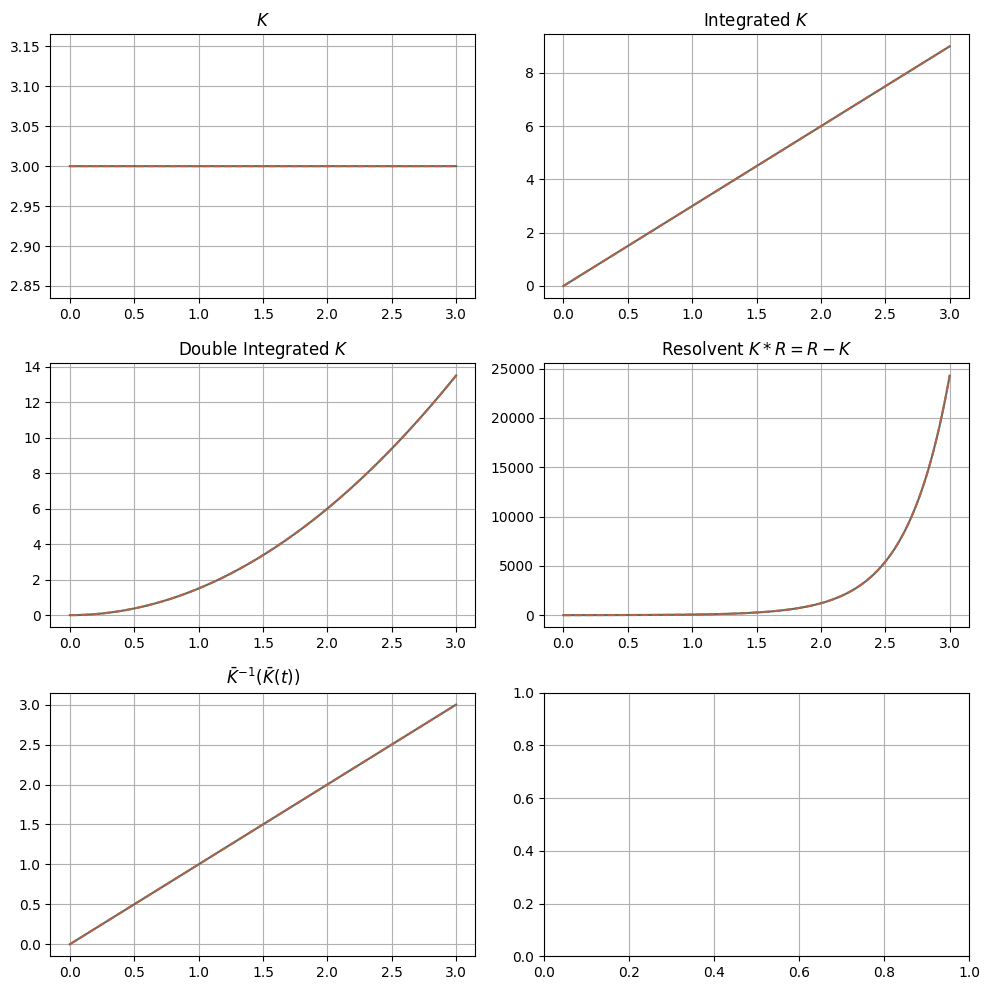

In [107]:
c = 3

K = ConstantKernel(c=c)

explicit_kernel = lambda t: c * np.ones_like(t)

t_grid = np.linspace(0, 3, 5000)

kernel_test(K=K, t_grid=t_grid, explicit_kernel=explicit_kernel)

## Exponential Kernel $K(t) = c e^{-\lambda t}$

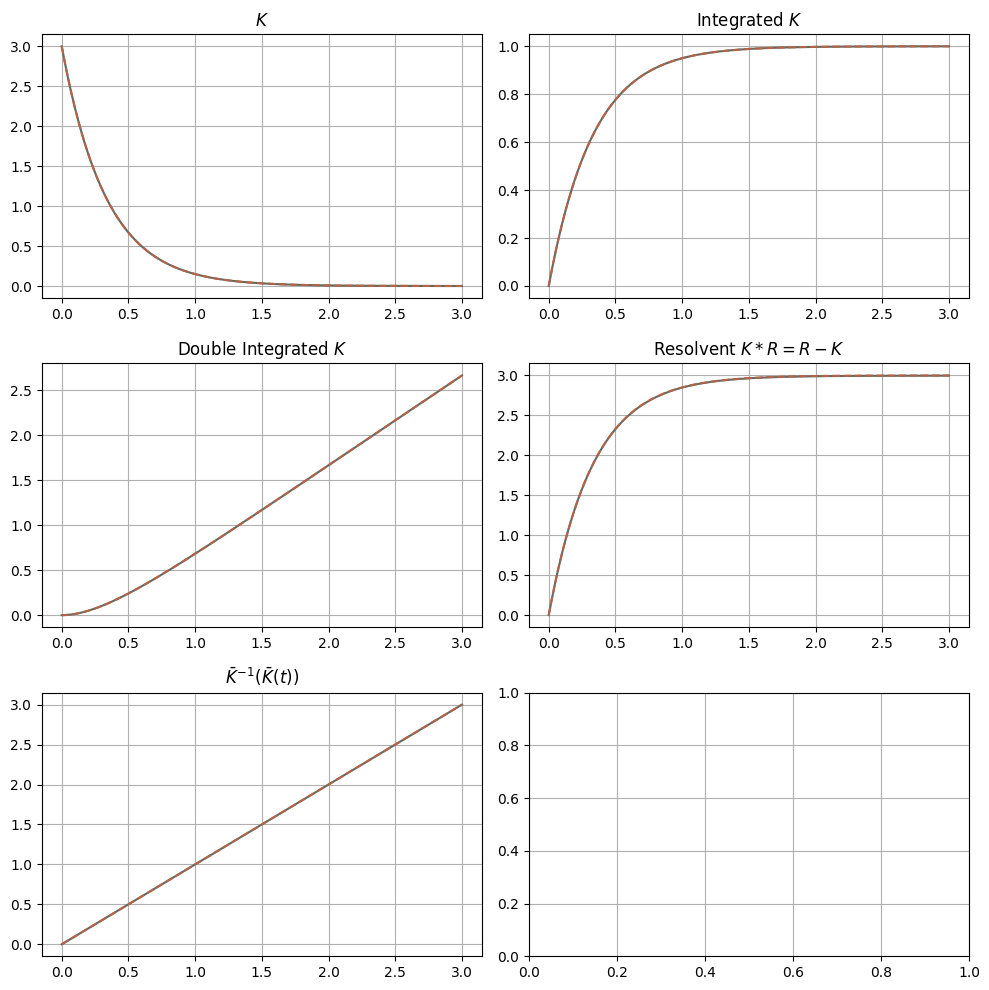

In [108]:
lam = 3
c = lam

K = ExponentialKernel(c=c, lam=lam)

explicit_kernel = lambda t: c * np.exp(-lam * t)

t_grid = np.linspace(0, 3, 5000)

kernel_test(K=K, t_grid=t_grid, explicit_kernel=explicit_kernel)

## Fractional Kernel $K(t) = c \frac{t^{H-0.5}}{\Gamma(H+0.5)}$

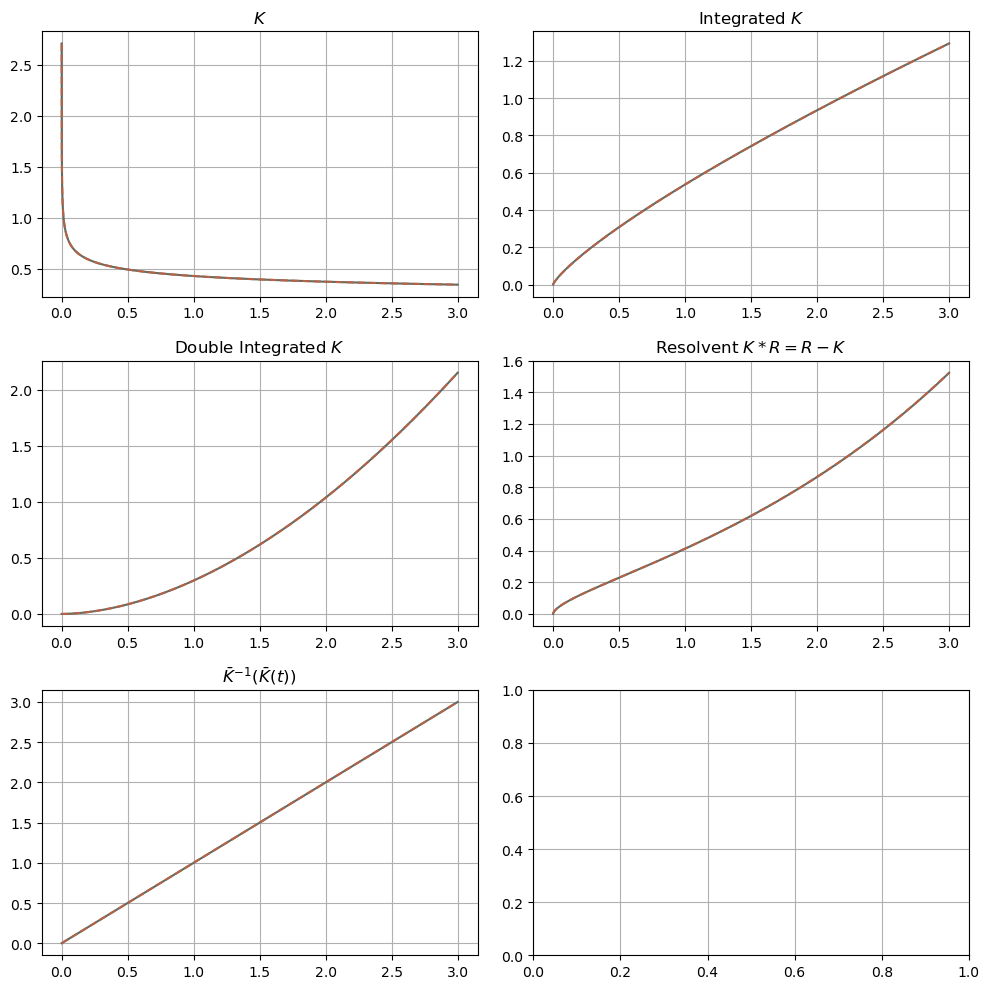

In [6]:
c, H = 0.5, 0.3

K = FractionalKernel(c=c, H=H)

explicit_kernel = lambda t: c * t**(H - 0.5) / gamma(H + 0.5)

t_grid = np.linspace(0.0001, 3, 10000)

kernel_test(K=K, t_grid=t_grid, explicit_kernel=explicit_kernel)

## Mittag-Leffler Kernel $K(t) = c t^{H-0.5} E_{\alpha, \alpha}(ct^\alpha)$

ValueError: x, y, and format string must not be None

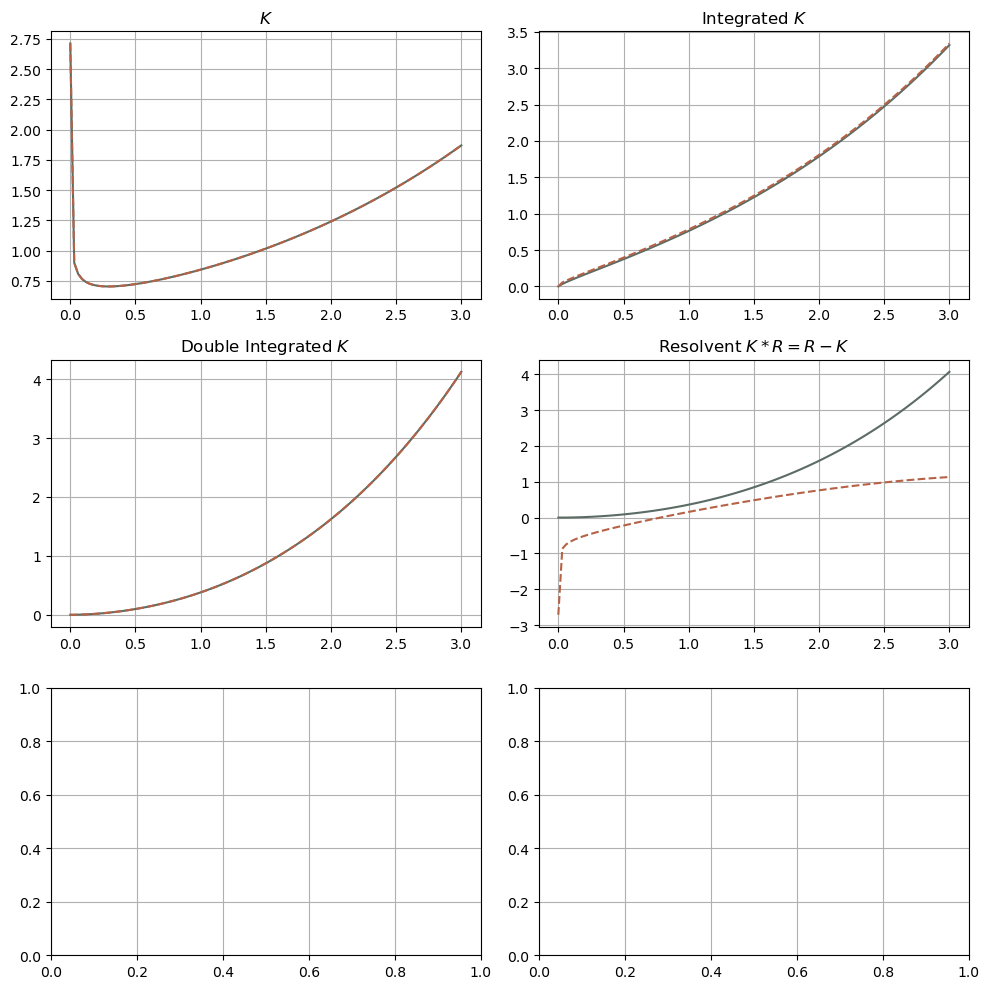

In [11]:
c, H = 0.5, 0.3
alpha = H + 0.5

K = MittagLefflerKernel(c=c, H=H)

explicit_kernel = lambda t:  c * t**(alpha - 1) * mittag_leffler(t=c * t**alpha, alpha=alpha, beta=alpha)

t_grid = np.linspace(0.0001, 3, 100)

kernel_test(K=K, t_grid=t_grid, explicit_kernel=explicit_kernel)

## Gamma Kernel $K(t) = c e^{-\lambda x}\frac{t^{H-0.5}}{\Gamma(H+0.5)}$

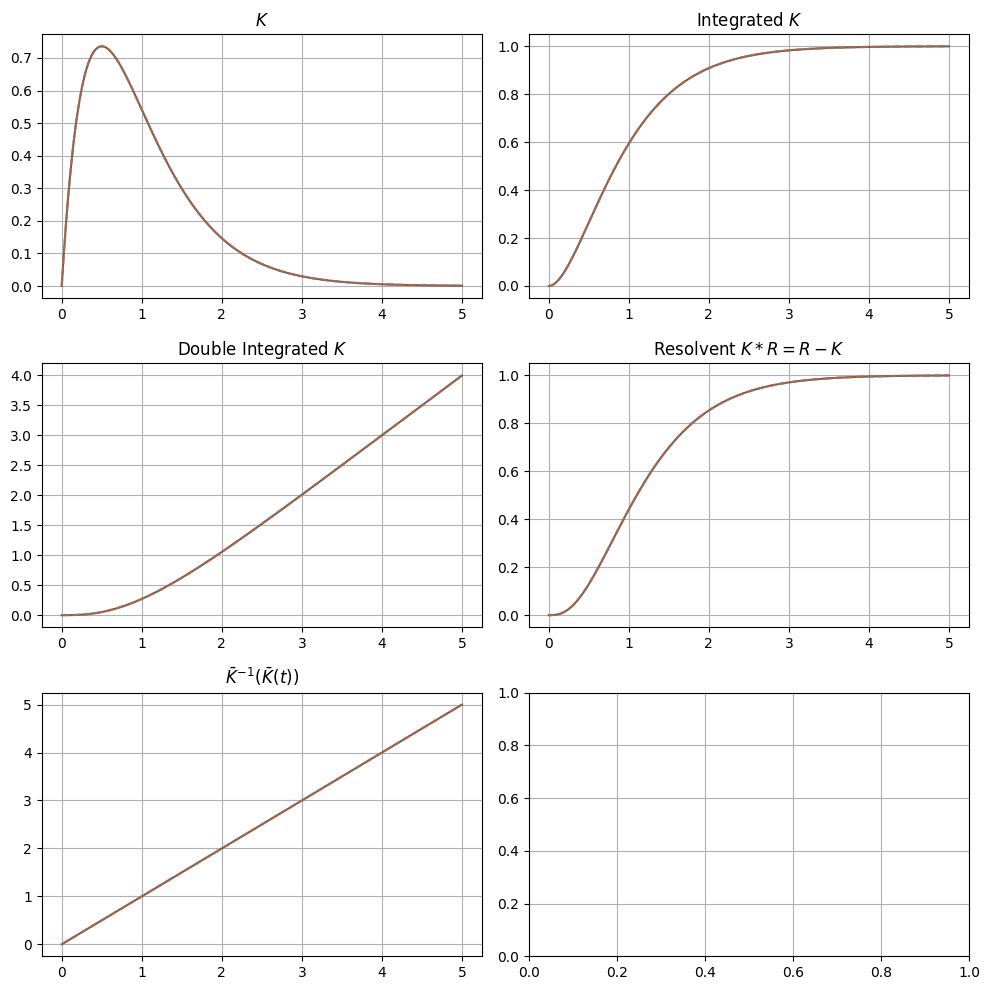

In [110]:
alpha, lam = 2, 2
c = lam**alpha

K = GammaKernel(c=c, alpha=alpha, lam=lam)

explicit_kernel = lambda t: c * np.exp(-lam * t) * t**(alpha - 1) / gamma(alpha)

t_grid = np.linspace(0.00001, 5, 1000)

kernel_test(K=K, t_grid=t_grid, explicit_kernel=explicit_kernel)